## Prueba de modelos ##

### Version 5: Modelo con 3 DER + 2 BESS, planificación anual, granularidad horaria ###


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandapower as pp

In [4]:
import pandas as pd

In [5]:
import pyomo.environ as pe

In [6]:
import math

In [7]:
import random

In [8]:
import matplotlib.pyplot as plt

In [9]:
import numpy as np

In [10]:
from ModelWriters.SimpleBusbar import SimpleModelWriter

In [11]:
import ModelWriters.Resources.ExtGrid  as ExtGrid

In [12]:
import ModelWriters.Resources.Load  as Load

In [13]:
import ModelWriters.Resources.PV  as PV

In [14]:
import ModelWriters.Resources.WT  as WT

In [15]:
import ModelWriters.Resources.Storage as Storage

In [16]:
import ModelWriters.Simulation.ElectricityCost as ElectricityCost

In [17]:
import ModelWriters.Simulation.Demand as Demand

In [18]:
import ModelWriters.Simulation.Solar as Solar

In [19]:
import ModelWriters.Simulation.Wind as Wind

In [20]:
net = pp.create_empty_network() 
b0 = pp.create_bus(net, vn_kv=13.2)

pp.create_ext_grid(net, bus=b0)

#ramal 1
b11 = pp.create_bus(net, vn_kv=13.2)
b12 = pp.create_bus(net, vn_kv=13.2)

pp.create_line(net, from_bus=b0, to_bus=b11, length_km=0.8, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b11, to_bus=b12, length_km=2.1, std_type="NAYY 4x50 SE")

pp.create_sgen(net, b11, p_mw=0.075, q_mvar=0.025, max_p_mw=0.15, max_q_mvar=0.15)
pp.create_load(net, bus=b12, p_mw=0.350)

#ramal 2
b21 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b21, length_km=5.0, std_type="NAYY 4x50 SE")
pp.create_sgen(net, b21, p_mw=0.15, q_mvar=0.00, max_p_mw=0.40, max_q_mvar=0.10)
pp.create_storage(net, bus=b21, p_mw=0.25, q_mvar=0.1, max_e_mwh = 3.0)

#ramal 3
b31 = pp.create_bus(net, vn_kv=13.2)
b32 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b31, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b31, to_bus=b32, length_km=1.5, std_type="NAYY 4x50 SE")
pp.create_sgen(net, b31, p_mw=0.08, q_mvar=0.00, max_p_mw=0.30, max_q_mvar=0.10)
pp.create_load(net, bus=b32, p_mw=0.85, q_mvar=0.33)


#ramal 4
b41 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b41, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_load(net, bus=b41, p_mw=0.22, q_mvar=0.05)
pp.create_storage(net, bus=b41, p_mw=0.5, q_mvar=0.1, max_e_mwh = 5.0)



1

In [21]:
 pp.runpp(net)

In [22]:
#print(net.res_bus.vm_pu)
#print(net.res_line)

In [23]:
print(net)

This pandapower network includes the following parameter tables:
   - bus (7 elements)
   - load (3 elements)
   - sgen (3 elements)
   - storage (2 elements)
   - ext_grid (1 element)
   - line (6 elements)
 and the following results tables:
   - res_bus (7 elements)
   - res_line (6 elements)
   - res_ext_grid (1 element)
   - res_load (3 elements)
   - res_sgen (3 elements)
   - res_storage (2 elements)


In [24]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar
0,None,1,0.075,0.025,NaN,1.0,True,wye,True,0.15,0.15
1,None,3,0.150,0.000,NaN,1.0,True,wye,True,0.40,0.10
2,None,4,0.080,0.000,NaN,1.0,True,wye,True,0.30,0.10


In [25]:
net.storage

,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type
0,None,3,0.25,0.1,NaN,NaN,0.0,3.0,1.0,True,None
1,None,6,0.50,0.1,NaN,NaN,0.0,5.0,1.0,True,None


Agregamos los parámetros del modelo a los elementos de la red.

In [26]:
def net_add_optfw(net):
    #agregamos parámetros para el modelo de optimización
    tables = [net.ext_grid, net.load, net.sgen, net.storage]

    for t in tables: 
        #initial cost
        t['model'] = None


In [27]:
net_add_optfw(net)

Vemos como queda por ejemplo el elemento de red externa:

In [28]:
net.ext_grid

,name,bus,vm_pu,va_degree,in_service,model
0,None,0,1.0,0.0,True,None


Defino una función normal de Python para que nos va a dar la componente lineal del costo de la energía

Variables que define el modelo:

y para el año

d para el día del año

h para la hora del día

dt la granularidad del modelo, en horas


temp la temperatura

wv la velocidad del viento

I la irradiación solar


eg el crecimiento económico en pu respecto al año 0


Estas variables llegan como parámetros en forma de diccionario en el argumento 'model_status' (ver este nombre)

Todas las funciones reciben este argumento, la lógica de la función indica que valor retorna. Pr ejemplo, si la granularidad es 24 h, debe retornar el valor medio del parámetro producido.

In [29]:
m = ExtGrid.ExtGrid('SET')
m['pr_mw'] = 5.0
m['pa_pu'] = 1.0
m['oc_1_mu'] = ElectricityCost.fixed_scalonated_electricity_cost
net.ext_grid['model'][0] = m
net.ext_grid['name'][0] = 'SET'



In [30]:
net.ext_grid

,name,bus,vm_pu,va_degree,in_service,model
0,SET,0,1.0,0.0,True,Resource: SET


In [31]:
m = Load.Load('Tornquinst')
m['pa_pu'] = Demand.scalonated_seasoned_randomized_demand
m['pr_mw'] = net.load['p_mw'][0]
net.load['model'][0] = m

m = Load.Load('Bell Ville')
m['pa_pu'] = Demand.scalonated_seasoned_randomized_demand
m['pr_mw'] = net.load['p_mw'][1]
net.load['model'][1] = m

m = Load.Load('City Bell')
m['pa_pu'] = Demand.scalonated_seasoned_randomized_demand
m['pr_mw'] = net.load['p_mw'][2]
net.load['model'][2] = m

In [32]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,model
0,None,2,0.35,0.00,0.0,0.0,NaN,1.0,True,wye,Resource: Tornquinst
1,None,5,0.85,0.33,0.0,0.0,NaN,1.0,True,wye,Resource: Bell Ville
2,None,6,0.22,0.05,0.0,0.0,NaN,1.0,True,wye,Resource: City Bell


In [33]:
m = PV.PVGeneratorDiscrete('PV1')
m.ic_0_mu = 0.5
m.ic_1_mu = 0.05
m.unit_cost_mu = 0.2
m.unit_size = 0.25
m.oc_0_mu = 0.0
m.oc_1_mu = 400e-6

net.sgen['name'][0] = m.name
net.sgen['model'][0] = m

m = PV.PVGenerator('PV2')
m.ic_0_mu = 3.0
m.ic_1_mu = 0.75
m.oc_0_mu = 0.0
m.oc_1_mu = 500e-6

net.sgen['name'][2] = m.name
net.sgen['model'][2] = m

In [34]:
m = WT.WTGenerator('WT1')
m.ic_0_mu = 5.0
m.ic_1_mu = 3.0
m.oc_0_mu = 0.0
m.oc_1_mu = 700e-6

net.sgen['name'][1] = m.name
net.sgen['model'][1] = m

In [35]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar,model
0,PV1,1,0.075,0.025,NaN,1.0,True,wye,True,0.15,0.15,Resource: PV1
1,WT1,3,0.150,0.000,NaN,1.0,True,wye,True,0.40,0.10,Resource: WT1
2,PV2,4,0.080,0.000,NaN,1.0,True,wye,True,0.30,0.10,Resource: PV2


In [36]:
m = Storage.Storage('ST1')

m.pa_pu = 1.0
m.ic_0_mu = 0.5
m.ic_1_mu = 1.0
m.ic_1_mu_cap = 0.5
m.oc_0_mu = 0.0

net.storage['name'][0] = 'ST1'
net.storage['model'][0] = m


m = Storage.Storage('ST2')
net.storage['name'][1] = 'ST2'
net.storage['model'][1] = m

m.pa_pu = 1.0
m.ic_0_mu = 0.5
m.ic_1_mu = 2.0
m.ic_1_mu_cap = 7.0
m.oc_0_mu = 0.0
m.oc_1_mu = 1400e-6


In [37]:
net.storage

,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type,model
0,ST1,3,0.25,0.1,NaN,NaN,0.0,3.0,1.0,True,None,Resource: ST1
1,ST2,6,0.50,0.1,NaN,NaN,0.0,5.0,1.0,True,None,Resource: ST2


## Construcción de Escenarios

In [38]:
dias = 365
años = 5

In [39]:
#el rango de horas:
T_i = range(24)
#T_i = range(5)

#el rango de dias:
Dias_i = range(dias)

Escenarios_i = range(len(T_i)*len(Dias_i))

In [40]:
m_s_base = [{'y': 0, 'd': 0, 'dd':1.0, 'h': 0.0, 'dt': 1.0, 'temp': 20.0, 'I':1000.0, 'wv': 10.0, 'eg': 1.0}]

registros = len(Dias_i)*len(T_i)

Escenarios =  pd.DataFrame(m_s_base, index = Escenarios_i)

reg = 0
for d in Dias_i:
    for h in T_i:
        Escenarios['d'][reg] = d
        Escenarios['h'][reg] = h
        Escenarios['I'][reg] = Solar.solar_irradiance_seasoned_randomized(d, h)
        Escenarios['wv'][reg] = random.uniform(1.0, 20.0)
        reg += 1

In [41]:
Escenarios

,y,d,dd,h,dt,temp,I,wv,eg
0,0,0,1.0,0.0,1.0,20.0,0.000000,11.530971,1.0
1,0,0,1.0,1.0,1.0,20.0,0.000000,9.601593,1.0
2,0,0,1.0,2.0,1.0,20.0,0.000000,14.140347,1.0
3,0,0,1.0,3.0,1.0,20.0,0.000000,9.994890,1.0
4,0,0,1.0,4.0,1.0,20.0,0.000000,18.948604,1.0
...,...,...,...,...,...,...,...,...,...
8755,0,364,1.0,19.0,1.0,20.0,207.436346,1.414152,1.0
8756,0,364,1.0,20.0,1.0,20.0,18.599948,16.747833,1.0
8757,0,364,1.0,21.0,1.0,20.0,0.000000,11.385944,1.0
8758,0,364,1.0,22.0,1.0,20.0,0.000000,7.821123,1.0


## Construcción del Modelo

Construccion automatica del modelo
Es un modelo de dimensionamiento de 3 DERs (WT+PV)

In [42]:
model_writer = SimpleModelWriter(net, Escenarios)

In [43]:
model = model_writer.create_model()

In [44]:
#model.pprint()

In [45]:
#solver_manager = pe.SolverManagerFactory('neos')
#result_obj = solver_manager.solve(model.model, opt='cplex')

opt = pe.SolverFactory('cplex')
#opt = pe.SolverFactory('glpk')
result_obj= opt.solve(model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\jmsar\AppData\Local\Temp\tmpw2u7e10_.cplex.log' open.
CPLEX> Problem 'C:\Users\jmsar\AppData\Local\Temp\tmp2gwz3szr.pyomo.lp' read.
Read time = 0.31 sec. (12.81 ticks)
CPLEX> Problem name         : C:\Users\jmsar\AppData\Local\Temp\tmp2gwz3szr.pyomo.lp
Objective sense      : Minimize
Variables            :   70094  [Nneg: 43808,  Box: 8760,  Free: 17520,
                                 Binary: 5,  General Integer: 1]
Objective nonzeros   :   43813
Linear constraints   :  122649  [Less: 96367,  Equal: 26282]
  Nonzeros           :  288162
  RHS nonzeros       :    8761

Variables     

In [46]:
model_writer.backconfigure_network()

In [47]:
model_writer.net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar,model
0,PV1,1,0.075,0.025,NaN,1.0,True,wye,True,4.75,2.375,Resource: PV1
1,WT1,3,0.150,0.000,NaN,1.0,False,wye,True,0.00,0.000,Resource: WT1
2,PV2,4,0.080,0.000,NaN,1.0,False,wye,True,0.00,0.000,Resource: PV2


In [48]:
model_writer.net.sgen['model'][0].units.value

19.0

In [49]:
model_writer.net.storage

,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type,model
0,ST1,3,0.25,0.1,NaN,NaN,0.0,6.095678,1.0,True,None,Resource: ST1
1,ST2,6,0.50,0.1,NaN,NaN,0.0,0.000000,1.0,False,None,Resource: ST2


In [51]:
Resultados = model_writer.get_scenes_results()

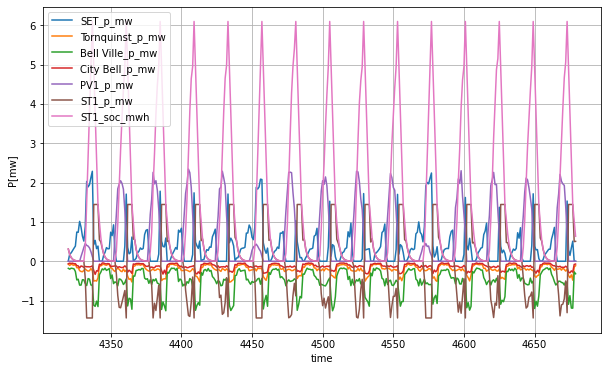

In [52]:
# Set the plot curve with markers and a title
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(10,6)
a=180*24
#b=360
b=180*24+15*24
for col in Resultados:
    ax.plot(Resultados[col][a:b], label = col)

#ax.plot(Resultados['Tornquinst'][a:b]+Resultados['Bell Ville'][a:b]+Resultados['City Bell'][a:b], label = 'Load')

#ax.plot(Resultados['time'][240:360], Resultados['p_mw_PV'][240:360], label = 'PV')
#ax.plot(Resultados['time'][240:360], Resultados['p_mw_Load'][240:360], label = 'Load')

ax.set_xlabel('time')
ax.set_ylabel('P[mw]')

ax.legend()

ax.grid(True)


plt.show()

## Prueba 2: Simple WTG fixed size, select units

In [53]:
from ModelWriters.Resources.WT import WTGeneratorDiscrete

In [54]:
net = pp.create_empty_network() 
b0 = pp.create_bus(net, vn_kv=13.2)

pp.create_ext_grid(net, bus=b0)

#ramal 1
b11 = pp.create_bus(net, vn_kv=13.2)
b12 = pp.create_bus(net, vn_kv=13.2)

pp.create_line(net, from_bus=b0, to_bus=b11, length_km=0.8, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b11, to_bus=b12, length_km=2.1, std_type="NAYY 4x50 SE")

##pp.create_sgen(net, b11, p_mw=0.075, q_mvar=0.025, max_p_mw=0.15, max_q_mvar=0.15)
pp.create_load(net, bus=b12, p_mw=0.350)

#ramal 2
b21 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b21, length_km=5.0, std_type="NAYY 4x50 SE")
pp.create_sgen(net, b21, p_mw=0.15, q_mvar=0.00, max_p_mw=0.40, max_q_mvar=0.10)
##pp.create_storage(net, bus=b21, p_mw=0.25, q_mvar=0.1, max_e_mwh = 3.0)

#ramal 3
b31 = pp.create_bus(net, vn_kv=13.2)
b32 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b31, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b31, to_bus=b32, length_km=1.5, std_type="NAYY 4x50 SE")
##pp.create_sgen(net, b31, p_mw=0.08, q_mvar=0.00, max_p_mw=0.30, max_q_mvar=0.10)
pp.create_load(net, bus=b32, p_mw=0.85, q_mvar=0.33)


#ramal 4
b41 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b41, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_load(net, bus=b41, p_mw=0.22, q_mvar=0.05)
##pp.create_storage(net, bus=b41, p_mw=0.5, q_mvar=0.1, max_e_mwh = 5.0)


2

In [55]:
net_add_optfw(net)

In [56]:
m = ExtGrid.ExtGrid('SET')
m['pr_mw'] = 5.0
m['pa_pu'] = 1.0
m['oc_1_mu'] = ElectricityCost.fixed_scalonated_electricity_cost
net.ext_grid['model'][0] = m
net.ext_grid['name'][0] = 'SET'



In [57]:
m = Load.Load('Tornquinst')
m['pa_pu'] = Demand.scalonated_seasoned_randomized_demand
m['pr_mw'] = net.load['p_mw'][0]
net.load['model'][0] = m

m = Load.Load('Bell Ville')
m['pa_pu'] = Demand.scalonated_seasoned_randomized_demand
m['pr_mw'] = net.load['p_mw'][1]
net.load['model'][1] = m

m = Load.Load('City Bell')
m['pa_pu'] = Demand.scalonated_seasoned_randomized_demand
m['pr_mw'] = net.load['p_mw'][2]
net.load['model'][2] = m

In [58]:
m = WTGeneratorDiscrete('WT1')
m.ic_0_mu = 1.0
m.ic_1_mu = 0.0
m.unit_cost_mu = 0.2
m.unit_size_mw = 0.3
m.oc_0_mu = 0.0
m.oc_1_mu = 700e-6

net.sgen['name'][0] = m.name
net.sgen['model'][0] = m

In [59]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar,model
0,WT1,3,0.15,0.0,NaN,1.0,True,wye,True,0.4,0.1,Resource: WT1


In [60]:
model_writer = SimpleModelWriter(net, Escenarios)

In [61]:
model = model_writer.create_model()

In [62]:
#model.pprint()

In [63]:
#solver_manager = pe.SolverManagerFactory('neos')
#result_obj = solver_manager.solve(model.model, opt='cplex')

opt = pe.SolverFactory('cplex')
#opt = pe.SolverFactory('glpk')
result_obj= opt.solve(model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\jmsar\AppData\Local\Temp\tmpskmvx9o2.cplex.log' open.
CPLEX> Problem 'C:\Users\jmsar\AppData\Local\Temp\tmppulareap.pyomo.lp' read.
Read time = 0.08 sec. (1.61 ticks)
CPLEX> Problem name         : C:\Users\jmsar\AppData\Local\Temp\tmppulareap.pyomo.lp
Objective sense      : Minimize
Variables            :   17524  [Nneg: 8762,  Box: 8760,  Binary: 1,
                                 General Integer: 1]
Objective nonzeros   :   17522
Linear constraints   :   17523  [Less: 8761,  Equal: 8762]
  Nonzeros           :   34116
  RHS nonzeros       :    8761

Variables            : Min LB: 0

In [64]:
model_writer.backconfigure_network()

In [65]:
model_writer.net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar,model
0,WT1,3,0.15,0.0,NaN,1.0,True,wye,True,3.3,1.65,Resource: WT1


In [66]:
model_writer.net.sgen['model'][0].units.value

11.0

In [67]:
model_writer.net.storage

,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type,model


In [68]:
Resultados = model_writer.get_scenes_results()

In [69]:
Resultados

,SET_p_mw,Tornquinst_p_mw,Bell Ville_p_mw,City Bell_p_mw,WT1_p_mw
0,0.000000,-0.091069,-0.228428,-0.065215,0.384711
1,0.000000,-0.088736,-0.184073,-0.045720,0.318530
2,0.000000,-0.102728,-0.205990,-0.060369,0.369087
3,0.000000,-0.104883,-0.230431,-0.060069,0.395383
4,0.000000,-0.078469,-0.236127,-0.047325,0.361921
...,...,...,...,...,...
8755,1.653131,-0.475723,-0.878646,-0.298763,0.000000
8756,0.000000,-0.467839,-1.039345,-0.323269,1.830453
8757,0.000000,-0.491709,-0.979737,-0.227967,1.699413
8758,0.000000,-0.121738,-0.362340,-0.070535,0.554613


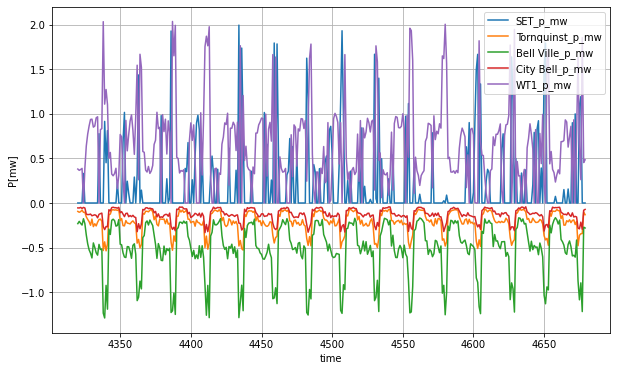

In [70]:
# Set the plot curve with markers and a title
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(10,6)
a=180*24
#b=360
b=180*24+15*24
for col in Resultados:
    ax.plot(Resultados[col][a:b], label = col)

#ax.plot(Resultados['Tornquinst'][a:b]+Resultados['Bell Ville'][a:b]+Resultados['City Bell'][a:b], label = 'Load')

#ax.plot(Resultados['time'][240:360], Resultados['p_mw_PV'][240:360], label = 'PV')
#ax.plot(Resultados['time'][240:360], Resultados['p_mw_Load'][240:360], label = 'Load')

ax.set_xlabel('time')
ax.set_ylabel('P[mw]')

ax.legend()

ax.grid(True)


plt.show()